## Import library

In [1]:
import datetime 
from datetime import timedelta 
import os
import glob
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve
from torch import nn, optim

import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from itertools import cycle
from tqdm.notebook import tqdm
import re
from sklearn.metrics import roc_auc_score, plot_roc_curve

import matplotlib.pyplot as plt
import seaborn
from collections import defaultdict

from sklearn import svm

import matplotlib.font_manager as fm
import seaborn as sns
from itertools import product

## Data load

In [2]:
# df_israel_covid 이스라엘 데이터셋
# corona_isolation_per_day_ver_0059 일일 코로나 격리자 수 
# time_series_covid19_confirmed_global 누적 확진자 수 

base_path = './opendataset'
df_israel_covid = pd.read_csv(f'{base_path}/israel_covid_large_2.csv')
# df_israel_covid = pd.read_csv(f'{base_path}/israel_covid_small.csv')
df_israel_isolation_per_day = pd.read_csv(f'{base_path}/corona_isolation_per_day_ver_0069.csv')
df_timeseries_confirm = pd.read_csv(f'{base_path}/time_series_covid19_confirmed_global.csv')

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_timeseries_confirm.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/28/21,8/29/21,8/30/21,8/31/21,9/1/21,9/2/21,9/3/21,9/4/21,9/5/21,9/6/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,152960,152960,153148,153220,153260,153306,153375,153375,153375,153534
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,144079,144847,145333,146387,147369,148222,149117,150101,150997,151499
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,194671,195162,195574,196080,196527,196915,197308,197659,198004,198313
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,15025,15025,15032,15033,15046,15052,15055,15055,15055,15069
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,47079,47168,47331,47544,47781,48004,48261,48475,48656,48790


## preprocessing

In [4]:
# 누적 확진자수를 2021-08-17 와 같은 포멧으로 전처리해주는 과정

rows = []
for idx, values in enumerate(df_timeseries_confirm[df_timeseries_confirm['Country/Region'] == 'Israel'].iteritems()):
    if idx < 4: continue
    year = f"20{values[0][-2:]}"
    month = values[0][:values[0].index('/')]
    month = f'0{month}' if len(month) == 1 else month
    day = values[0][values[0].index('/') + 1 : values[0].rindex('/')]
    day = f'0{day}' if len(day) == 1 else day
    date = f'{year}-{month}-{day}'
    confirmed_num = values[1].item()
    rows.append([date, confirmed_num])
df_numsum_confirmed = pd.DataFrame(rows, columns=['confirmed_date', 'confirmed_numsum'])

In [5]:
# 누적 확진자를 통해 일일 확진자 구하기

df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_numsum'] - df_numsum_confirmed.shift(1)['confirmed_numsum']
df_numsum_confirmed = df_numsum_confirmed.dropna()
df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_num'].astype(int)

In [6]:
# 일일 확진자수가 음수인 경우 그 전날 확진자를 가져다 쓰는 과정

for idx, row in df_numsum_confirmed[df_numsum_confirmed['confirmed_num'] < 0].iterrows():
    print("before", df_numsum_confirmed.loc[idx,'confirmed_num'])
    df_numsum_confirmed.loc[idx,'confirmed_num'] = df_numsum_confirmed.loc[idx-1,'confirmed_num']
    print("after", df_numsum_confirmed.loc[idx,'confirmed_num'])
    print()

before -28
after 28

before -53
after 34



In [7]:
df_numsum_confirmed.head(5)
# df_numsum_confirmed.tail(5)

,confirmed_date,confirmed_numsum,confirmed_num
1,2020-01-23,0,0
2,2020-01-24,0,0
3,2020-01-25,0,0
4,2020-01-26,0,0
5,2020-01-27,0,0


In [8]:
df_israel_covid = df_israel_covid[df_israel_covid['test_date'] < '2021-09-01']
df_israel_isolation_per_day = df_israel_isolation_per_day[df_israel_isolation_per_day['date'] < '2021-09-01']
df_numsum_confirmed = df_numsum_confirmed[df_numsum_confirmed['confirmed_date'] < '2021-06-01']

In [9]:
df_israel_isolation_per_day['join_date'] = (pd.to_datetime(df_israel_isolation_per_day['date']) + timedelta(days=1)).dt.strftime('%Y-%m-%d')

# 요일을 숫자로 기록한 컬럼 하나 만듬
df_israel_covid['weekday'] = pd.to_datetime(df_israel_covid['test_date']).dt.dayofweek

In [10]:
# 기존 이스라엘 데이터에 격리자 컬럼을 넣어주는 과정

df_israel_covid = pd.merge(df_israel_covid, df_israel_isolation_per_day, how='left', left_on='test_date', right_on='join_date')

In [11]:
df_israel_covid = df_israel_covid.sort_values('test_date')
df_israel_covid.head(5)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,weekday,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad,join_date
6925780,2020-03-11,0,0,0,0,0,שלילי,NaN,זכר,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925531,2020-03-11,1,0,1,0,0,שלילי,NaN,נקבה,Abroad,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925532,2020-03-11,1,0,0,1,0,שלילי,NaN,נקבה,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925533,2020-03-11,0,0,0,0,0,שלילי,NaN,זכר,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925534,2020-03-11,0,0,0,0,0,שלילי,NaN,נקבה,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11


In [12]:
# 기존 이스라엘 데이터에 일일 확진자랑 일일 누적 확진자 컬럼을 넣어주는 과정

df_israel_covid = pd.merge(df_israel_covid, df_numsum_confirmed, how='left', left_on='test_date', right_on='confirmed_date')

In [13]:
df_israel_covid.shape[0]

6925781

In [14]:
head_ne = df_israel_covid[df_israel_covid['head_ache'] == 0]
head_po = df_israel_covid[df_israel_covid['head_ache'] == 1]
print(head_ne.shape[0]+head_po.shape[0])

6925781


## 번역하기

In [15]:
def gender_map(gender):
    if gender == 'נקבה': return 1 #'Female'
    elif gender == 'זכר': return 0 #'Male'
    return -1

In [16]:
def corona_result_map(corona_result):
    if corona_result == 'אחר': return -1 # 'Other'
    elif corona_result == 'שלילי': return 0 # 'Negative'
    elif corona_result == 'חיובי': return 1 # 'Positive'
    return ''

In [17]:
def corona_result_map_vis(corona_result):
    if corona_result == -1: return 'Other'
    elif corona_result == 0: return 'Negative' 
    elif corona_result == 1: return 'Positive' 
    return ''

In [18]:
def age_60_and_above_map(age_60_and_above):
    if age_60_and_above == 'Yes': return 1
    elif age_60_and_above == 'No': return 0
    return -1

In [19]:
def test_indication_map(test_indication):
    if test_indication == 'Other': return 0
    elif test_indication == 'Abroad': return 1
    elif  test_indication == 'Contact with confirmed': return 2
    else: return -1

In [20]:
df_israel_covid['gender'] = df_israel_covid['gender'].apply(gender_map)
df_israel_covid['corona_result'] = df_israel_covid['corona_result'].apply(corona_result_map)
df_israel_covid['age_60_and_above'] = df_israel_covid['age_60_and_above'].apply(age_60_and_above_map)
df_israel_covid['test_indication'] = df_israel_covid['test_indication'].apply(test_indication_map)

## Data 기초 통계

In [21]:
df_israel_covid_for_vis = df_israel_covid

In [22]:
df_israel_covid_for_vis['corona result'] = df_israel_covid_for_vis['corona_result'].apply(corona_result_map_vis)

In [23]:
df_israel_covid_for_vis['corona result']

0          Negative
1          Negative
2          Negative
3          Negative
4          Negative
             ...   
6925776    Negative
6925777    Negative
6925778    Negative
6925779    Negative
6925780       Other
Name: corona result, Length: 6925781, dtype: object

In [24]:
# 양성 데이터 수
num_of_pos = df_israel_covid[df_israel_covid['corona_result'] == 1].shape[0]

In [25]:
num_of_pos

479575

In [26]:
# 음성 데이터 수
num_of_neg = df_israel_covid[df_israel_covid['corona_result'] == 0].shape[0]

In [27]:
num_of_neg

6297341

In [28]:
SAVE_FLAG = False

In [29]:
pic_path = './eda_result'

<AxesSubplot:xlabel='corona result', ylabel='count'>

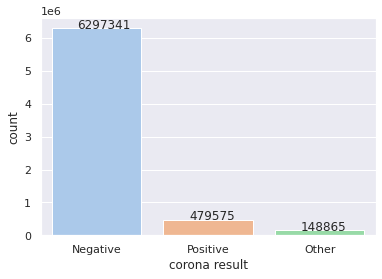

In [30]:
sns.set(style="darkgrid")
g = sns.countplot(data=df_israel_covid_for_vis, x='corona result', \
                  order=df_israel_covid_for_vis['corona result'].value_counts().index, palette='pastel')
for p in g.patches:
        g.annotate('{:}'.format(p.get_height()), (p.get_x()+0.23, p.get_height()+ 100))

if SAVE_FLAG: plt.savefig(f'{pic_path}/corona_result.png')
g

In [31]:
# other 데이터 수
num_of_oth = df_israel_covid[df_israel_covid['corona_result'] == -1].shape[0]

In [32]:
num_of_oth

148865

In [33]:
print(f"양성/음성 비율: {round(num_of_pos/num_of_neg, 2)}")

양성/음성 비율: 0.08


In [34]:
total_num = num_of_pos + num_of_neg + num_of_oth
total_num

6925781

In [35]:
df_israel_covid.columns

Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication', 'weekday', 'date',
       'isolated_today_contact_with_confirmed', 'isolated_today_abroad',
       'new_contact_with_confirmed', 'new_from_abroad', 'join_date',
       'confirmed_date', 'confirmed_numsum', 'confirmed_num', 'corona result'],
      dtype='object')

## 증상 유, 증상 무, 증상갯수/전체갯수, 전체 증상 갯수

In [36]:
num_cough = df_israel_covid[df_israel_covid['cough'] == 1].shape[0]
num_not_cough = df_israel_covid[df_israel_covid['cough'] == 0].shape[0]
print(num_cough, num_not_cough, num_cough/total_num, num_cough+num_not_cough)

290244 6635537 0.041907764626112204 6925781


In [37]:
pd.DataFrame(data=[[1,2,3],[4,5,6]], columns=[1, 2, 3])
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)
crashes.head(5)

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
40,23.9,9.082,9.799,22.944,19.359,858.97,116.29,SC
34,23.9,5.497,10.038,23.661,20.554,688.75,109.72,ND
48,23.8,8.092,6.664,23.086,20.706,992.61,152.56,WV
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
17,21.4,4.066,4.922,16.692,16.264,872.51,137.13,KY


In [38]:
def get_symptom_num(df, attr):
    num_symp = df[df[attr] == 1].shape[0]
    num_symp_not = df[df[attr] == 0].shape[0]
    total = num_symp + num_symp_not
    ratio = num_symp / total
    return num_symp, num_symp_not, ratio, total

In [39]:
num_cough, num_not_cough, ratio_cough, total_cough = get_symptom_num(df_israel_covid, 'cough')
print(num_cough, num_not_cough, ratio_cough, total_cough)

290244 6635537 0.041907764626112204 6925781


In [40]:
num_fever, num_not_fever, ratio_fever, total_fever = get_symptom_num(df_israel_covid, 'fever')
print(num_fever, num_not_fever, ratio_fever, total_fever)

228526 6697255 0.032996423074884984 6925781


In [41]:
num_sore_throat, num_not_sore_throat, ratio_sore_throat, total_sore_throat = get_symptom_num(df_israel_covid, 'sore_throat')
print(num_sore_throat, num_not_sore_throat, ratio_sore_throat, total_sore_throat)

108427 6817354 0.015655562888864088 6925781


In [42]:
num_shortness_of_breath, num_not_shortness_of_breath, ratio_shortness_of_breath, total_shortness_of_breath = get_symptom_num(df_israel_covid, 'shortness_of_breath')
print(num_shortness_of_breath, num_not_shortness_of_breath, ratio_shortness_of_breath, total_shortness_of_breath)

27998 6897783 0.004042576570064806 6925781


In [43]:
num_head_ache, num_not_head_ache, ratio_head_ache, total_head_ache = get_symptom_num(df_israel_covid, 'head_ache')
print(num_head_ache, num_not_head_ache, ratio_head_ache, total_head_ache)

222259 6703522 0.032091543177585315 6925781


In [44]:
num_60_up = df_israel_covid[df_israel_covid['age_60_and_above'] == 1].shape[0]
num_60_down = df_israel_covid[df_israel_covid['age_60_and_above'] == 0].shape[0]
num_unk = df_israel_covid[df_israel_covid['age_60_and_above'] == -1].shape[0]
print(num_60_up, num_60_down, num_unk,  num_60_up/(num_60_up+num_60_down+num_unk), num_60_up+num_60_down+num_unk)

690868 4822913 1412000 0.09975308199898322 6925781


In [45]:
num_other = df_israel_covid[df_israel_covid['test_indication'] == 0].shape[0]
num_abroad = df_israel_covid[df_israel_covid['test_indication'] == 1].shape[0]
num_contact = df_israel_covid[df_israel_covid['test_indication'] == 2].shape[0]
# num_unk = df_israel_covid[df_israel_covid['test_indication'] == -1].shape[0]
print(num_other, num_abroad, num_contact, num_other+num_abroad+num_contact)

6412347 25649 487785 6925781


In [46]:
ratio_symp = [ratio_cough, ratio_fever, ratio_sore_throat, ratio_shortness_of_breath, ratio_head_ache]

In [47]:
df_symptom = pd.DataFrame(columns=['Symptom', 'Total', '# of symptoms'])
df_symptom.loc[-1] = ['Cough', num_cough+num_not_cough, num_cough]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Fever',  num_fever+num_not_fever, num_fever]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Sore throat', num_sore_throat+num_not_sore_throat, num_sore_throat]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Shortness of breath', num_shortness_of_breath+num_not_shortness_of_breath, num_shortness_of_breath]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Headache', num_head_ache+num_not_head_ache, num_head_ache]
df_symptom = df_symptom.reset_index(drop=True)

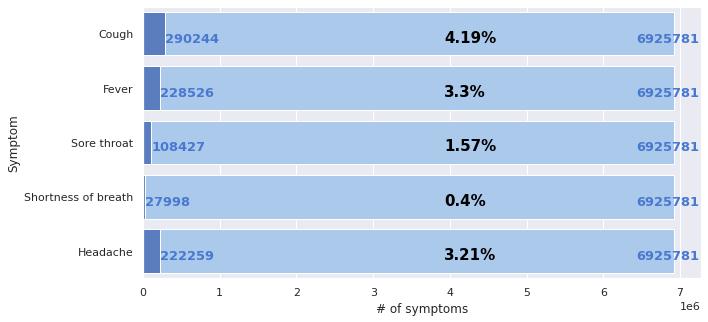

In [48]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
g1 = sns.barplot(x="Total", y="Symptom", data=df_symptom, label="Total", color="b")
sns.set_color_codes("muted")
g2 = sns.barplot(x="# of symptoms", y="Symptom", data=df_symptom, label="# of symptoms", color="b")

for i, v in enumerate(df_symptom['Total'].values):
    ax.text(v - 500000, i + .15, str(v), color='b', size=13, weight='bold')
    percent_symp = round(ratio_symp[i]*100, 2)
    ax.text(v - 3000000, i + .15, f'{percent_symp}%', color='black', size=15, weight='bold')

for i, v in enumerate(df_symptom['# of symptoms'].values):
    ax.text(v - 3, i + .15, str(v), color='b', size=13, weight='bold')

if SAVE_FLAG: plt.savefig(f'{pic_path}/증상유무 비율.png')
plt.show()

In [49]:
df_israel_covid_p = df_israel_covid[df_israel_covid['corona_result'] == 1]
num_cough, num_not_cough, ratio_cough, total_cough = get_symptom_num(df_israel_covid_p, 'cough')
num_fever, num_not_fever, ratio_fever, total_fever = get_symptom_num(df_israel_covid_p, 'fever')
num_sore_throat, num_not_sore_throat, ratio_sore_throat, total_sore_throat = get_symptom_num(df_israel_covid_p, 'sore_throat')
num_shortness_of_breath, num_not_shortness_of_breath, ratio_shortness_of_breath, total_shortness_of_breath = get_symptom_num(df_israel_covid_p, 'shortness_of_breath')
num_head_ache, num_not_head_ache, ratio_head_ache, total_head_ache = get_symptom_num(df_israel_covid_p, 'head_ache')
ratio_symp = [ratio_cough, ratio_fever, ratio_sore_throat, ratio_shortness_of_breath, ratio_head_ache]

In [50]:
df_symptom = pd.DataFrame(columns=['Symptom', 'Total', '# of symptoms'])
df_symptom.loc[-1] = ['Cough', num_cough+num_not_cough, num_cough]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Fever',  num_fever+num_not_fever, num_fever]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Sore throat', num_sore_throat+num_not_sore_throat, num_sore_throat]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Shortness of breath', num_shortness_of_breath+num_not_shortness_of_breath, num_shortness_of_breath]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Headache', num_head_ache+num_not_head_ache, num_head_ache]
df_symptom = df_symptom.reset_index(drop=True)

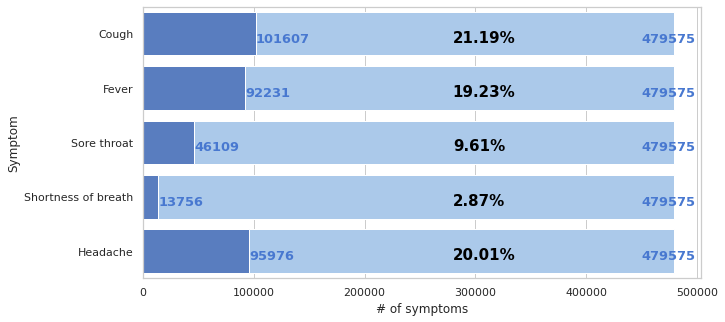

In [51]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
g1 = sns.barplot(x="Total", y="Symptom", data=df_symptom, label="Total", color="b")
sns.set_color_codes("muted")
g2 = sns.barplot(x="# of symptoms", y="Symptom", data=df_symptom, label="# of symptoms", color="b")

for i, v in enumerate(df_symptom['Total'].values):
    ax.text(v-30000, i + .15, str(v), color='b', size=13, weight='bold')
    percent_symp = round(ratio_symp[i]*100, 2)
    ax.text(v - 200000, i + .15, f'{percent_symp}%', color='black', size=15, weight='bold')

for i, v in enumerate(df_symptom['# of symptoms'].values):
    ax.text(v - 3, i + .15, str(v), color='b', size=13, weight='bold')
if SAVE_FLAG:  plt.savefig(f'{pic_path}/양성_증상유무비율.png')
plt.show()

In [52]:
df_israel_covid_n = df_israel_covid[df_israel_covid['corona_result'] == 0]
num_cough, num_not_cough, ratio_cough, total_cough = get_symptom_num(df_israel_covid_n, 'cough')
num_fever, num_not_fever, ratio_fever, total_fever = get_symptom_num(df_israel_covid_n, 'fever')
num_sore_throat, num_not_sore_throat, ratio_sore_throat, total_sore_throat = get_symptom_num(df_israel_covid_n, 'sore_throat')
num_shortness_of_breath, num_not_shortness_of_breath, ratio_shortness_of_breath, total_shortness_of_breath = get_symptom_num(df_israel_covid_n, 'shortness_of_breath')
num_head_ache, num_not_head_ache, ratio_head_ache, total_head_ache = get_symptom_num(df_israel_covid_n, 'head_ache')
ratio_symp = [ratio_cough, ratio_fever, ratio_sore_throat, ratio_shortness_of_breath, ratio_head_ache]

In [53]:
df_symptom = pd.DataFrame(columns=['Symptom', 'Total', '# of symptoms'])
df_symptom.loc[-1] = ['Cough', num_cough+num_not_cough, num_cough]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Fever',  num_fever+num_not_fever, num_fever]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Sore throat', num_sore_throat+num_not_sore_throat, num_sore_throat]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Shortness of breath', num_shortness_of_breath+num_not_shortness_of_breath, num_shortness_of_breath]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Headache', num_head_ache+num_not_head_ache, num_head_ache]
df_symptom = df_symptom.reset_index(drop=True)

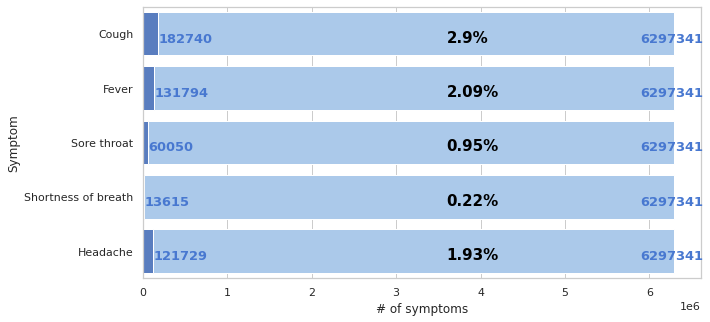

In [54]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
g1 = sns.barplot(x="Total", y="Symptom", data=df_symptom, label="Total", color="b")
sns.set_color_codes("muted")
g2 = sns.barplot(x="# of symptoms", y="Symptom", data=df_symptom, label="# of symptoms", color="b")

for i, v in enumerate(df_symptom['Total'].values):
    ax.text(v-400000, i + .15, str(v), color='b', size=13, weight='bold')
    percent_symp = round(ratio_symp[i]*100, 2)
    ax.text(v - 2700000, i + .15, f'{percent_symp}%', color='black', size=15, weight='bold')

for i, v in enumerate(df_symptom['# of symptoms'].values):
    ax.text(v - 3, i + .15, str(v), color='b', size=13, weight='bold')

if SAVE_FLAG: plt.savefig(f'{pic_path}/음성_증상유무비율.png')
plt.show()

In [55]:
df_israel_covid_o = df_israel_covid[df_israel_covid['corona_result'] == -1]
num_cough, num_not_cough, ratio_cough, total_cough = get_symptom_num(df_israel_covid_o, 'cough')
num_fever, num_not_fever, ratio_fever, total_fever = get_symptom_num(df_israel_covid_o, 'fever')
num_sore_throat, num_not_sore_throat, ratio_sore_throat, total_sore_throat = get_symptom_num(df_israel_covid_o, 'sore_throat')
num_shortness_of_breath, num_not_shortness_of_breath, ratio_shortness_of_breath, total_shortness_of_breath = get_symptom_num(df_israel_covid_o, 'shortness_of_breath')
num_head_ache, num_not_head_ache, ratio_head_ache, total_head_ache = get_symptom_num(df_israel_covid_o, 'head_ache')
ratio_symp = [ratio_cough, ratio_fever, ratio_sore_throat, ratio_shortness_of_breath, ratio_head_ache]

In [56]:
df_symptom = pd.DataFrame(columns=['Symptom', 'Total', '# of symptoms'])
df_symptom.loc[-1] = ['Cough', num_cough+num_not_cough, num_cough]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Fever',  num_fever+num_not_fever, num_fever]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Sore throat', num_sore_throat+num_not_sore_throat, num_sore_throat]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Shortness of breath', num_shortness_of_breath+num_not_shortness_of_breath, num_shortness_of_breath]
df_symptom.index = df_symptom.index + 1
df_symptom.loc[-1] = ['Headache', num_head_ache+num_not_head_ache, num_head_ache]
df_symptom = df_symptom.reset_index(drop=True)

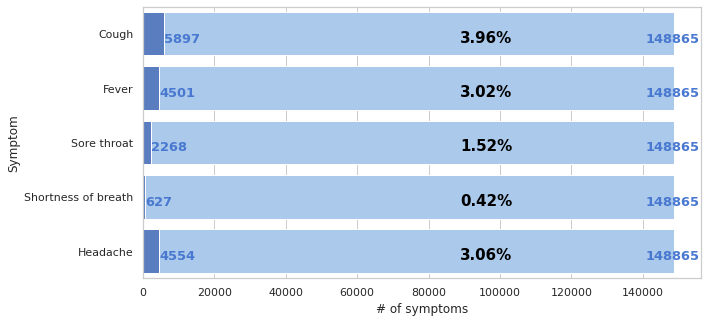

In [57]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
g1 = sns.barplot(x="Total", y="Symptom", data=df_symptom, label="Total", color="b")
sns.set_color_codes("muted")
g2 = sns.barplot(x="# of symptoms", y="Symptom", data=df_symptom, label="# of symptoms", color="b")

for i, v in enumerate(df_symptom['Total'].values):
    ax.text(v-8000, i + .15, str(v), color='b', size=13, weight='bold')
    percent_symp = round(ratio_symp[i]*100, 2)
    ax.text(v - 60000, i + .15, f'{percent_symp}%', color='black', size=15, weight='bold')
for i, v in enumerate(df_symptom['# of symptoms'].values):
    ax.text(v - 3, i + .15, str(v), color='b', size=13, weight='bold')
if SAVE_FLAG: plt.savefig(f'{pic_path}/기타 증상유무비율.png')
plt.show()

## data를 코로나 결과가 양성, 음성, 기타인 데이터로 분리해서 비교 

In [58]:
df_israel_covid_p.tail(5)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,...,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad,join_date,confirmed_date,confirmed_numsum,confirmed_num,corona result
6925041,2021-08-31,0,0,0,0,0,1,0,-1,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Positive
6925044,2021-08-31,0,0,0,0,0,1,0,1,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Positive
6925099,2021-08-31,0,0,0,0,0,1,-1,1,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Positive
6925552,2021-08-31,0,0,0,0,0,1,0,0,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Positive
6925554,2021-08-31,0,0,0,0,0,1,0,0,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Positive


In [59]:
df_israel_covid_n.tail(5)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,...,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad,join_date,confirmed_date,confirmed_numsum,confirmed_num,corona result
6925775,2021-08-31,0,0,0,0,0,0,1,0,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Negative
6925776,2021-08-31,0,0,0,0,0,0,0,0,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Negative
6925777,2021-08-31,0,0,0,0,0,0,1,0,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Negative
6925778,2021-08-31,0,0,0,0,0,0,0,1,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Negative
6925779,2021-08-31,0,0,0,0,0,0,0,1,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Negative


In [60]:
df_israel_covid_o.tail(5)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,...,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad,join_date,confirmed_date,confirmed_numsum,confirmed_num,corona result
6925140,2021-08-31,0,0,0,0,0,-1,0,0,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Other
6925225,2021-08-31,0,0,0,0,0,-1,0,0,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Other
6925534,2021-08-31,0,0,0,0,0,-1,0,0,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Other
6925734,2021-08-31,0,0,0,0,0,-1,0,1,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Other
6925780,2021-08-31,0,0,0,0,0,-1,0,1,0,...,2021-08-30,30785,76593,6446,8006,2021-08-31,NaN,NaN,NaN,Other


In [61]:
# 데이터 갯수 & 증상 비율들
def cnt_has_symptom(df):
    fever_cnt = df[df['fever'] == 1].shape[0]
    cough_cnt = df[df['cough'] == 1].shape[0]    
    sore_throat_cnt = df[df['sore_throat'] == 1].shape[0]
    shortness_of_breath_cnt = df[df['shortness_of_breath'] == 1].shape[0]
    head_ache_cnt = df[df['head_ache'] == 1].shape[0]
    total = fever_cnt+cough_cnt+sore_throat_cnt+shortness_of_breath_cnt+head_ache_cnt
    
    fever_percent = round(100 * fever_cnt / total, 1)
    cough_percent = round(100 * cough_cnt / total, 1)
    sore_throat_percent = round(100 * sore_throat_cnt / total, 1)
    shortness_of_breath_percent = round(100 * shortness_of_breath_cnt / total, 1)
    head_ache_percent = round(100 * head_ache_cnt / total, 1)
    
    return fever_percent, cough_percent, sore_throat_percent, shortness_of_breath_percent, head_ache_percent

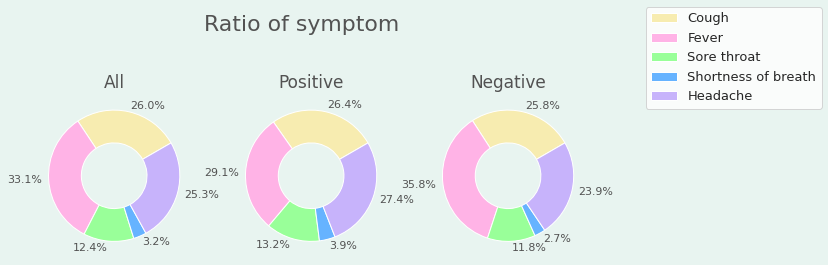

In [62]:
ratio1 = [*cnt_has_symptom(df_israel_covid)]
ratio2 = [*cnt_has_symptom(df_israel_covid_p)]
ratio3 = [*cnt_has_symptom(df_israel_covid_n)]

font_color = '#525252'
colors = ['#f7ecb0', '#ffb3e6', '#99ff99', '#66b3ff', '#c7b3fb','#ff6666']
labels = ['Cough', 'Fever', 'Sore throat', 'Shortness of breath', 'Headache']
title = 'Symptom Ratio'

fig, axes = plt.subplots(1, 3, figsize=(10, 5), facecolor='#e8f4f0')

ax = axes[0]
ax.pie(ratio1, labels=[str(v) + '%' for v in ratio1], \
        wedgeprops=dict(width=.5), \
        colors=colors, startangle=30, \
        textprops={'color':font_color})
ax.set_title('All', fontsize=17, color=font_color)

ax = axes[1]
ax.pie(ratio2, labels=[str(v) + '%' for v in ratio2], \
        wedgeprops=dict(width=.5), \
        colors=colors, startangle=30, \
        textprops={'color':font_color})
ax.set_title('Positive', fontsize=17, color=font_color)

ax = axes[2]
ax.pie(ratio3, labels=[str(v) + '%' for v in ratio3], \
        wedgeprops=dict(width=.5), \
        colors=colors, startangle=30, \
        textprops={'color':font_color})
ax.set_title('Negative', fontsize=17, color=font_color)

legend = plt.legend(labels, 
                        bbox_to_anchor=(1.3, .87), # Legend position
                        loc='lower left',  
                        ncol=1,
                        fontsize=13,
                        fancybox=True)
title = fig.suptitle('Ratio of symptom', y=.95, fontsize=22, color=font_color)


if SAVE_FLAG: plt.savefig(f'{pic_path}/코로나검진결과에따른증상비율.png')

## 양성 음성에 따른 증상 갯수 차이 비교

In [63]:
# pos_list = [0] * 6
# for idx, row in df_israel_covid_p.iterrows():
#     cnt_idx = row['cough'] + row['fever'] + row['sore_throat'] + \
#             + row['shortness_of_breath'] + row['head_ache']
#     pos_list[cnt_idx] += 1
# print(pos_list)

In [64]:
# df_pos_symnum = pd.DataFrame(pos_list, columns= ['# of people'])
# df_pos_symnum = df_pos_symnum.reset_index()
# df_pos_symnum = df_pos_symnum.rename(columns={'index': '# of symptoms'})

In [65]:
# sns.set(style="darkgrid")
# g = sns.barplot(data= df_pos_symnum, x= "# of symptoms", y="# of people", palette='pastel')
# for p in g.patches:
#         g.annotate(int(p.get_height()), (p.get_x()+0.03, p.get_height()+ 10))
# g.set_title('Positive')
# if SAVE_FLAG: plt.savefig(f'{pic_path}/양성_증상갯수분포.png')

In [66]:
print(234848/428599, 102525/428599, 62485/428599, 22067/428599, 5775/428599, 899/428599)

0.5479434156402605 0.23920961084836875 0.14578895424394364 0.05148635437786836 0.013474133164099776 0.0020975317254589955


In [67]:
# neg_list = [0] * 6
# for idx, row in df_israel_covid_n.iterrows():
#     cnt_idx = row['cough'] + row['fever'] + row['sore_throat'] + \
#             + row['shortness_of_breath'] + row['head_ache']
#     neg_list[cnt_idx] += 1
# print(neg_list)

In [68]:
# neg_list

In [69]:
# df_neg_symnum = pd.DataFrame(neg_list, columns= ['# of people'])
# df_neg_symnum = df_neg_symnum.reset_index()
# df_neg_symnum = df_neg_symnum.rename(columns={'index': '# of symptoms'})

In [70]:
# sns.set(style="darkgrid")
# g = sns.barplot(data= df_neg_symnum, x= "# of symptoms", y="# of people", palette='pastel')
# for p in g.patches:
#         g.annotate(int(p.get_height()), (p.get_x()+0.01, p.get_height()+ 10))
# g.set_title('Negative')
# if SAVE_FLAG: plt.savefig(f'{pic_path}/음성_증상갯수분포.png')

In [71]:
def count_has_symptom(df):
    cough_cnt = df[df['cough'] == 1].shape[0]
    fever_cnt = df[df['fever'] == 1].shape[0]
    sore_throat_cnt = df[df['sore_throat'] == 1].shape[0]
    shortness_of_breath_cnt = df[df['shortness_of_breath'] == 1].shape[0]
    head_ache_cnt = df[df['head_ache'] == 1].shape[0]
    
    return cough_cnt, fever_cnt, sore_throat_cnt, shortness_of_breath_cnt, head_ache_cnt

In [72]:
dz_names = ['Cough', 'Fever', 'Sore th', 'short bre', 'Headache']
pos_symp_nums = [*count_has_symptom(df_israel_covid_p)]
neg_symp_nums = [*count_has_symptom(df_israel_covid_n)]

rowss = []
# df_for_symptoms_vis.index = df_for_symptoms_vis.index + 1
rowss.append([[dz_name, pos_symp_num, 'Positive'] for dz_name, pos_symp_num in zip(dz_names, pos_symp_nums)])
rowss.append([[dz_name, neg_symp_num, 'Negative'] for dz_name, neg_symp_num in zip(dz_names, neg_symp_nums)])

df_for_symptoms_vis = pd.DataFrame(columns=['Symptom', '# of Symptoms', 'Corona result'])
for rows in rowss:
    for row in rows:
        df_for_symptoms_vis.loc[-1] = row
        df_for_symptoms_vis.index = df_for_symptoms_vis.index + 1

In [73]:
df_for_symptoms_vis

,Symptom,# of Symptoms,Corona result
9,Cough,101607,Positive
8,Fever,92231,Positive
7,Sore th,46109,Positive
6,short bre,13756,Positive
5,Headache,95976,Positive
4,Cough,182740,Negative
3,Fever,131794,Negative
2,Sore th,60050,Negative
1,short bre,13615,Negative
0,Headache,121729,Negative


/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 720x720 with 0 Axes>

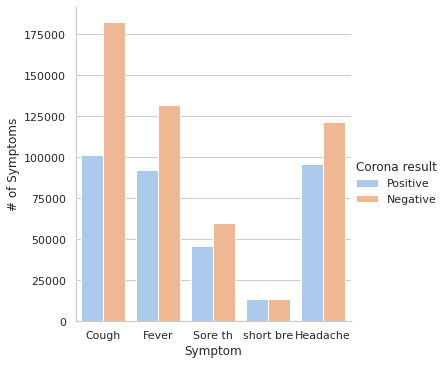

In [74]:
plt.figure(figsize = (10,10))
sns.factorplot(x='Symptom', y='# of Symptoms', hue='Corona result', data=df_for_symptoms_vis, kind='bar', palette='pastel')
if SAVE_FLAG: plt.savefig(f'{pic_path}/코로나검진결과분포by증상.png')

## rulebasemodel preprocessing

In [75]:
df_rulebase = pd.read_excel('rulebasemodel_chart.xlsx')

In [76]:
df_rulebase.head(5)

,cough,fever,sore_throat,shortness_of_breath,head_ache,sex,result,cough_2,fever_2,sore_throat_2,...,sex_2,result_2,Unnamed: 14,Unnamed: 15,Unnamed: 16,sex,"male: 0, female:1, dontknow -1",Unnamed: 19,Unnamed: 20,"설문에는 있는데, 남녀 차이가 없이 결과가 나온다"
0,0,0,0,0,0,-1,0,0,0,0,...,-1,0,NaN,NaN,NaN,result,"LOW: 0, MEDIUM: 1, HIGH=2 VERY LOW:3",NaN,NaN,NaN
1,1,0,0,0,0,-1,1,1,0,0,...,-1,0,NaN,NaN,NaN,test_indication,contact:1 non contact 0,NaN,NaN,contact이면 무조건 HIGH 나와서 제외
2,0,1,0,0,0,-1,1,0,1,0,...,-1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,1,0,0,-1,1,0,0,1,...,-1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,1,0,-1,1,0,0,0,...,-1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
df_symtoma_rule = df_rulebase[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'result']]
df_shine1_rule  = df_rulebase[['cough_2', 'fever_2', 'sore_throat_2', 'shortness_of_breath_2', 'head_ache_2', 'result_2']]

In [78]:
df_shine1_rule = df_shine1_rule.rename(columns={'cough_2': 'cough', 'fever_2': 'fever', 'sore_throat_2': 'sore_throat', 'shortness_of_breath_2': 'shortness_of_breath', 'head_ache_2': 'head_ache', 'result_2': 'result'})

In [79]:
display(df_symtoma_rule.head(5))
display(df_shine1_rule.head(5))

,cough,fever,sore_throat,shortness_of_breath,head_ache,result
0,0,0,0,0,0,0
1,1,0,0,0,0,1
2,0,1,0,0,0,1
3,0,0,1,0,0,1
4,0,0,0,1,0,1


,cough,fever,sore_throat,shortness_of_breath,head_ache,result
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,0,0,1,0,0,1
4,0,0,0,1,0,2


## model input preprocessing

In [80]:
# other 빼버림
df_israel_covid_without_o = df_israel_covid[df_israel_covid['corona_result'] != -1]

In [81]:
df_israel_covid_without_o.shape[0]

6776916

In [82]:
# 성별 없는 사람들 빼버림
df_israel_covid_without_o = df_israel_covid_without_o[df_israel_covid_without_o['gender'] != -1]

In [83]:
df_israel_covid_without_o.shape[0]

6275088

In [84]:
df_israel_covid_without_o = df_israel_covid_without_o.sort_values(['test_date']).reset_index(drop=True)

In [85]:
df_israel_covid_without_o['test_date'].min()

'2020-03-11'

In [86]:
# # week_num 이라는 칼럼을 새로 만들었다. 1년에 52주라 
# def date_to_weeknum_map(test_date):
#     week_num_st_idx = 52
#     year_last_num = int(test_date[2:4])
#     week_num = datetime.date(int(test_date[:4]), int(test_date[5:7]), int(test_date[8:])).isocalendar()[1]
#     return week_num_st_idx * year_last_num + week_num

# Add 2nd degree data
추가 feature
- new_contact_with_confirmed
- positive_ratio
- weekday_ratio
- confirmed_ratio

In [87]:
df_israel_covid_without_o['new_contact_with_confirmed'] = df_israel_covid_without_o['new_contact_with_confirmed'].astype(int)

In [88]:
df_israel_covid_without_o['contact'] = df_israel_covid_without_o['new_contact_with_confirmed'] / 36903

In [89]:
df_confirm_by_sampling = df_israel_covid_without_o[df_israel_covid_without_o['corona_result'] == 1].groupby('test_date').count().reset_index()[['test_date', 'date']]
df_confirm_by_sampling = df_confirm_by_sampling.rename(columns={'test_date': 'yesterday', 'date': 'positive_cnt'})

In [90]:
df_israel_covid_without_o = pd.merge(df_israel_covid_without_o, df_confirm_by_sampling, how='left', left_on='date', right_on='yesterday')

In [91]:
df_israel_covid_without_o.shape[0]

6275088

In [92]:
df_israel_covid_without_o = df_israel_covid_without_o[~df_israel_covid_without_o['positive_cnt'].isnull()]

In [93]:
df_israel_covid_without_o['positive_cnt'] = df_israel_covid_without_o['positive_cnt'].astype(int)

In [94]:
df_israel_covid_without_o['positive_ratio'] = df_israel_covid_without_o['positive_cnt'] / df_israel_covid_without_o['positive_cnt'].max()

In [95]:
df_israel_covid_without_o['weekday_ratio'] = df_israel_covid_without_o['weekday'] / 6

In [96]:
df_israel_covid_without_o['confirmed_ratio'] = df_israel_covid_without_o['confirmed_num'] / df_israel_covid_without_o['confirmed_num'].max()

In [97]:
df_israel_covid_without_o['confirmed_num'].max()

11934.0

In [98]:
df_israel_covid_without_o['confirmed_ratio'] = df_israel_covid_without_o['confirmed_ratio'] * 100

In [99]:
df_israel_covid_without_o[df_israel_covid_without_o['confirmed_num'] < 1000].shape[0]

1485775

In [100]:
df_israel_covid_without_o[df_israel_covid_without_o['confirmed_num'] < 2000].shape[0]

2661085

In [101]:
df_israel_covid_without_o[df_israel_covid_without_o['confirmed_num'] < 3000].shape[0]

3154933

In [102]:
df_israel_covid_without_o[df_israel_covid_without_o['confirmed_num'] < 4000].shape[0]

3597657

In [103]:
df_israel_covid_without_o[df_israel_covid_without_o['confirmed_num'] < 5000].shape[0]

4086290

In [104]:
df_israel_covid_without_o.columns

Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication', 'weekday', 'date',
       'isolated_today_contact_with_confirmed', 'isolated_today_abroad',
       'new_contact_with_confirmed', 'new_from_abroad', 'join_date',
       'confirmed_date', 'confirmed_numsum', 'confirmed_num', 'corona result',
       'contact', 'yesterday', 'positive_cnt', 'positive_ratio',
       'weekday_ratio', 'confirmed_ratio'],
      dtype='object')

In [105]:
df_israel_covid_without_o = df_israel_covid_without_o[~df_israel_covid_without_o['confirmed_ratio'].isnull()]

In [106]:
df_israel_covid_without_o['year'] = df_israel_covid_without_o['test_date'].apply(lambda x: int(x[:4]))
df_israel_covid_without_o['month'] = df_israel_covid_without_o['test_date'].apply(lambda x: int(x[5:7]))
df_israel_covid_without_o['day'] = df_israel_covid_without_o['test_date'].apply(lambda x: int(x[8:10]))

In [107]:
# 여기서 내가 사용할 feature 고르기
df_input_only_symptom = df_israel_covid_without_o[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'corona_result']]
df_input = df_israel_covid_without_o[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'gender', 'confirmed_ratio', 'test_indication', 'corona_result']]

raw_datas_only_symptom = df_input_only_symptom.values
raw_datas = df_input.values

In [108]:
df_input[df_input['confirmed_ratio'] < 0.05].shape[0]

10110

In [109]:
df_input[df_input['confirmed_ratio'] < 0.1].shape[0]

10110

In [110]:
df_input[df_input['confirmed_ratio'] < 0.15].shape[0]

12358

In [111]:
df_input[df_input['confirmed_ratio'] < 0.2].shape[0]

12990

In [112]:
df_input[df_input['confirmed_ratio'] >= 0.2].shape[0]

5332923

In [113]:
df_israel_covid_without_o

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,...,corona result,contact,yesterday,positive_cnt,positive_ratio,weekday_ratio,confirmed_ratio,year,month,day
361,2020-03-12,1,1,1,1,0,0,-1,1,0,...,Negative,0.056174,2020-03-11,42,0.007795,0.5,0.175968,2020,3,12
362,2020-03-12,0,0,0,0,0,0,-1,0,0,...,Negative,0.056174,2020-03-11,42,0.007795,0.5,0.175968,2020,3,12
363,2020-03-12,0,0,0,0,0,0,-1,1,0,...,Negative,0.056174,2020-03-11,42,0.007795,0.5,0.175968,2020,3,12
364,2020-03-12,0,0,0,0,0,0,-1,1,0,...,Negative,0.056174,2020-03-11,42,0.007795,0.5,0.175968,2020,3,12
365,2020-03-12,0,0,0,0,0,0,-1,1,0,...,Negative,0.056174,2020-03-11,42,0.007795,0.5,0.175968,2020,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375922,2021-04-22,0,0,0,0,0,0,-1,1,0,...,Negative,0.018237,2021-04-21,42,0.007795,0.5,2.639517,2021,4,22
5375923,2021-04-22,0,0,0,0,0,0,-1,1,0,...,Negative,0.018237,2021-04-21,42,0.007795,0.5,2.639517,2021,4,22
5375924,2021-04-22,0,0,0,0,0,0,-1,0,0,...,Negative,0.018237,2021-04-21,42,0.007795,0.5,2.639517,2021,4,22
5375925,2021-04-22,0,0,0,0,0,0,-1,0,0,...,Negative,0.018237,2021-04-21,42,0.007795,0.5,2.639517,2021,4,22


In [114]:
df_input.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache,gender,confirmed_ratio,test_indication,corona_result
count,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06
mean,4.963493e-02,3.851017e-02,1.842978e-02,4.828174e-03,3.798640e-02,5.207305e-01,2.597199e+01,1.719158e-01,7.944592e-02
std,2.171896e-01,1.924244e-01,1.344995e-01,6.931713e-02,1.911634e-01,4.995701e-01,2.258918e+01,5.568187e-01,2.704335e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.315234e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.680912e+01,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.026311e+01,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+02,2.000000e+00,1.000000e+00


In [141]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)).astype(int)
    test_set_size = int(len(data) * test_ratio)
    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    print(len(data))
    print(test_indices.dtype)
    print(train_indices.dtype)
    
    test_data = data[:test_set_size]
    train_data = data[test_set_size:]
    test_data = data[test_indices]
    train_data = data[train_indices]
    
    return train_data, test_data

In [142]:
def split_input_gt(non_split_data):
    splited_input = non_split_data[:, :-1]
    splited_gt = non_split_data[:, -1]
    
    return splited_input, splited_gt

In [143]:
not_test_datas, test_datas = split_train_test(raw_datas, test_ratio=0.2)
train_datas, valid_datas = split_train_test(not_test_datas, test_ratio=0.2)

train_input, train_gt = split_input_gt(train_datas)
valid_input, valid_gt = split_input_gt(valid_datas)
test_input, test_gt = split_input_gt(test_datas)

5345913
int64
int64
4276731
int64
int64


In [144]:
not_test_datas_only_symptom, test_datas_only_symptom = split_train_test(raw_datas_only_symptom, test_ratio=0.2)
train_datas_only_symptom, valid_datas_only_symptom = split_train_test(not_test_datas_only_symptom, test_ratio=0.2)

train_input_only_symptom, train_gt_only_symptom = split_input_gt(train_datas_only_symptom)
valid_input_only_symptom, valid_gt_only_symptom = split_input_gt(valid_datas_only_symptom)
test_input_only_symptom, test_gt_only_symptom = split_input_gt(train_datas_only_symptom)

5345913
int64
int64
4276731
int64
int64


In [145]:
print(train_input.shape, train_gt.shape, valid_input.shape, valid_gt.shape, test_input.shape, test_gt.shape)

(3421385, 8) (3421385,) (855346, 8) (855346,) (1069182, 8) (1069182,)


In [146]:
print(train_input_only_symptom.shape, train_gt_only_symptom.shape, valid_input_only_symptom.shape, valid_gt_only_symptom.shape, test_input_only_symptom.shape, test_gt_only_symptom.shape)

(3421385, 5) (3421385,) (855346, 5) (855346,) (3421385, 5) (3421385,)


In [147]:
train_input.shape

(3421385, 8)

In [148]:
from collections import defaultdict
def rulebase_classifier(input_data, dict_rule):
    result_by_rule = dict_rule[tuple(input_data)]
    dict_return_value = defaultdict(int)
    dict_return_value.update({
        0: 0,
        1: 0.3,
        2: 0.8,
    })
    return dict_return_value[result_by_rule]

In [149]:
def get_preds_by_rule(input_datas, dict_rule):
    preds = []
    for idx, input_data in enumerate(input_datas):
        preds.append(rulebase_classifier_2(input_data, dict_rule))
#         preds = [rulebase_classifier(input_data, df_rule) for input_data in input_datas]
    return np.array(preds, dtype=np.float64)

df_symtoma_rule

,cough,fever,sore_throat,shortness_of_breath,head_ache,result
0,0,0,0,0,0,0
1,1,0,0,0,0,1
2,0,1,0,0,0,1
3,0,0,1,0,0,1
4,0,0,0,1,0,1
5,0,0,0,0,1,0
6,1,1,0,0,0,1
7,1,0,1,0,0,1
8,1,0,0,1,0,1
9,1,0,0,0,1,1


In [150]:
def plot_roc_curve_for_dnn(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [151]:
def get_preds_by_rule(input_datas, df_rule):
    preds = []
    for idx, input_data in enumerate(input_datas):
        preds.append(rulebase_classifier(input_data, df_rule))
#         preds = [rulebase_classifier(input_data, df_rule) for input_data in input_datas]
    return np.array(preds, dtype=np.float64)

In [152]:
shine1_dict_rule = df_shine1_rule.set_index(['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']).to_dict()['result']
symtoma_dict_rule = df_symtoma_rule.set_index(['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']).to_dict()['result']

shine1_preds = get_preds_by_rule(valid_input_only_symptom, shine1_dict_rule)
symtoma_preds = get_preds_by_rule(valid_input_only_symptom, symtoma_dict_rule)

0.6378494687689437


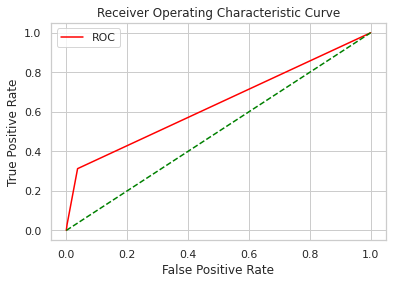

In [153]:
fper, tper, thresholds = roc_curve(valid_gt_only_symptom, shine1_preds)
print(roc_auc_score(valid_gt_only_symptom, shine1_preds))
plot_roc_curve_for_dnn(fper, tper)

0.6634921446925337


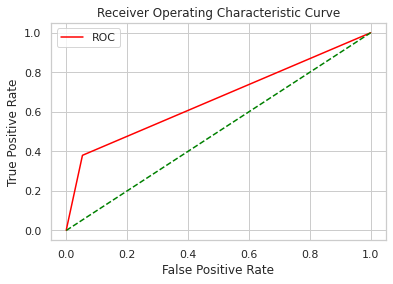

In [154]:
fper, tper, thresholds = roc_curve(valid_gt_only_symptom, symtoma_preds)
print(roc_auc_score(valid_gt_only_symptom, symtoma_preds))
plot_roc_curve_for_dnn(fper, tper)

In [155]:
print("# of train data positive: ", train_gt.sum())
print("# of train data negative: ", train_gt.shape[0] - train_gt.sum())
print("ratio of P/N: ", train_gt.sum()/(train_gt.shape[0] - train_gt.sum()))
print("")

print("# of valid data positive: ", valid_gt.sum())
print("# of valid data negative: ", valid_gt.shape[0] - valid_gt.sum())
print("ratio of P/N: ", valid_gt.sum()/(valid_gt.shape[0] - valid_gt.sum()))
print("")

print("# of test data positive: ", test_gt.sum())
print("# of test data negative: ", test_gt.shape[0] - test_gt.sum())
print("ratio of P/N: ", test_gt.sum()/(test_gt.shape[0] - test_gt.sum()))

# of train data positive:  271855.0
# of train data negative:  3149530.0
ratio of P/N:  0.08631605350639619

# of valid data positive:  67848.0
# of valid data negative:  787498.0
ratio of P/N:  0.08615640928611883

# of test data positive:  85008.0
# of test data negative:  984174.0
ratio of P/N:  0.08637497027964568


In [156]:
class IsraelDataset(Dataset):
    def __init__(self, input_data, gt, transform=None, target_transform=None):
        self.input_data = input_data
        self.gt = gt
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return self.input_data[idx], self.gt[idx]

In [157]:
def plot_roc_curve_for_dnn(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [158]:
def display_performance(clf, pred, valid_input, valid_gt, save_name=None):
    pred = np.array(pred)

    print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
    print('precision %.4f' % (precision_score(pred, valid_gt)))
    print('recall %.4f' % (recall_score(pred, valid_gt)))
    print('f1-score %.4f' % (f1_score(pred, valid_gt)))
    print(confusion_matrix(pred, valid_gt))
    
    plot_roc_curve(clf, valid_input, valid_gt)
    
    if save_name != None: plt.savefig(f'./eda_result/{save_name}.png')

In [159]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

logistic_clf = LogisticRegression(C=1000.0, random_state=0)
logistic_clf = logistic_clf.fit(train_input, train_gt)

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
pred = logistic_clf.predict(valid_input)
display_performance(logistic_clf, pred, valid_input, valid_gt, 'logistic_auc')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=5, random_state=0)
rf_clf.fit(train_input, train_gt)

In [ ]:
pred = rf_clf.predict(valid_input)
display_performance(rf_clf, pred, valid_input, valid_gt, 'randomforest_auc')

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(train_input, train_gt)

In [118]:
pred = dt_clf.predict(valid_input)
display_performance(dt_clf, pred, valid_input, valid_gt, 'decisiontree_auc')

NameError: name 'dt_clf' is not defined

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(train_input, train_gt)

In [ ]:
pred = gb_clf.predict(valid_input)
display_performance(gb_clf, pred, valid_input, valid_gt, 'gbm_auc')

In [119]:
df_input.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache,gender,confirmed_ratio,test_indication,corona_result
count,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06
mean,4.963493e-02,3.851017e-02,1.842978e-02,4.828174e-03,3.798640e-02,5.207305e-01,2.597199e+01,1.719158e-01,7.944592e-02
std,2.171896e-01,1.924244e-01,1.344995e-01,6.931713e-02,1.911634e-01,4.995701e-01,2.258918e+01,5.568187e-01,2.704335e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.315234e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.680912e+01,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.026311e+01,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+02,2.000000e+00,1.000000e+00


In [120]:
# class BaselineModel(nn.Module):
#     def __init__(self):
#         super(BaselineModel, self).__init__()
# #         nn.BatchNorm1d(9)
#         self.fcs1 = nn.Sequential(
#             nn.Linear(9, 400),
#             nn.BatchNorm1d(400),
#             nn.ReLU()
#         )
# #         dropout 넣기
# #         nn.linear, L1 norm L2 norm
#         self.fcs2 = nn.Sequential(
#             nn.Linear(400, 400),
#             nn.BatchNorm1d(400),
#             nn.ReLU()
#         )
#         self.fcs3 = nn.Sequential(
#             nn.Linear(400, 400),
#             nn.BatchNorm1d(400),
#             nn.ReLU()
#         )
#         self.fcs4 = nn.Sequential(
#             nn.Linear(400, 400),
#             nn.BatchNorm1d(400),
#             nn.ReLU()
#         )
#         self.fcs5 = nn.Sequential(
#             nn.Linear(400, 1),
# #             nn.Sigmoid()
#         )
    
#     def forward(self, x):
#         x = x.view(-1, 9)
#         x = self.fcs1(x)
#         x = x + self.fcs2(x)
#         x = x + self.fcs3(x)
#         x = x + self.fcs4(x)
#         pred = self.fcs5(x)
#         return pred

In [121]:
#  if test_indication == 'Other': return 0
#     elif test_indication == 'Abroad': return 1
#     elif  test_indication == 'Contact with confirmed': return 2

In [160]:
training_data = IsraelDataset(torch.Tensor(train_input), torch.Tensor(train_gt.reshape(-1, 1)))
valid_data = IsraelDataset(torch.Tensor(valid_input), torch.Tensor(valid_gt.reshape(-1, 1)))
test_data = IsraelDataset(torch.Tensor(test_input), torch.Tensor(test_gt.reshape(-1, 1)))
                          
train_dataloader = DataLoader(training_data, batch_size = 512, shuffle=False)
valid_dataloader = DataLoader(valid_data, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

train_input.shape, valid_input.shape, test_input.shape

((3421385, 8), (855346, 8), (1069182, 8))

In [161]:
for val_inputs, val_labels in valid_dataloader:
    break
print(val_inputs.shape)

print(val_inputs.shape)

torch.Size([128, 8])
torch.Size([128, 8])


In [162]:
import torch
from torch import Tensor
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional


def conv3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1) -> nn.Conv1d:
    return nn.Conv1d(in_planes, out_planes,
                     kernel_size=3,
                     stride=stride, padding=1,
                     groups=groups, bias=False,
                     )


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self, inplanes: int, planes: int, stride: int = 1, ) -> None:
        super(BasicBlock, self).__init__()
        norm_layer = nn.BatchNorm1d
        self.conv1 = conv3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, n_channels=64, dropout=0.2):

        super(ResNet, self).__init__()

        self.inplanes = 1
        self.outplanes = n_channels
        self.conv1 = nn.Conv1d(self.inplanes, self.outplanes, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(self.outplanes)
        self.relu = nn.ReLU(inplace=True)

        # Update inplanes for the next layer
        self.inplanes = self.outplanes

        # ResNet blocks
        self.layer1 = self._make_layer(block, n_channels, layers[0])
        self.layer2 = self._make_layer(block, n_channels, layers[1], stride=1,)
        self.layer3 = self._make_layer(block, n_channels, layers[2], stride=1,)
        self.layer4 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer5 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer6 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer7 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer8 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.avgpool = nn.AdaptiveAvgPool1d((1, ))
        
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(self.inplanes * block.expansion, num_classes)

    def _make_layer(self, block, planes: int, blocks: int, stride: int = 1, dilate: bool = False):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, stride))

        return nn.Sequential(*layers)

    def forward(self, x: Tensor):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [163]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [164]:
model = ResNet(BasicBlock, [2, 2, 2, 2], 1, n_channels=64, dropout=0.9).to(device)

In [165]:
model

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64

In [166]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr 크기좀 늘려보기

In [167]:
def show_progress(train_history, val_history):
    plt.plot(train_history)
    plt.plot(val_history)
    plt.legend(['train_loss', 'val_loss'])
    plt.show()

In [136]:
import gc

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/6683 [00:00<?, ?it/s]

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  0%|          | 0/6683 [00:00<?, ?it/s]

[[0.01125125]
 [0.01233296]
 [0.02775743]
 [0.00962135]
 [0.01748552]] [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Done. Train loss:0.19191623418479734, Validation loss: 0.1911073178950361 VAL_AUC:0.8642435339852217


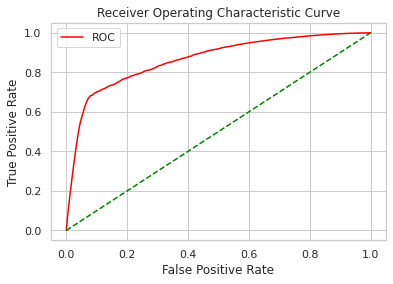

  0%|          | 0/6683 [00:00<?, ?it/s]

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [169]:
train_running_loss = 0.0
num_epochs = 20

train_history = []
val_history = []
torch.cuda.empty_cache()

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_losses = []
    for train_inputs, train_labels in tqdm(train_dataloader):
        train_inputs = torch.unsqueeze(train_inputs, 1)
        train_inputs = train_inputs.to(device)
        train_labels = train_labels.to(device)

        optimizer.zero_grad()
        
        train_outputs = model(train_inputs)
        train_outputs = nn.functional.sigmoid(train_outputs)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        
        ##
#         print('train loss]', train_loss)
        train_losses.append(train_loss.tolist())
    
#     del variables
    torch.cuda.empty_cache()
    
    model.eval()
    
    val_losses = []
    val_all_outputs = []
    val_all_labels = []
    for val_inputs, val_labels in tqdm(valid_dataloader):
        
        val_inputs = torch.unsqueeze(val_inputs, 1)
        val_outputs = model(torch.Tensor(val_inputs).to(device))
        
        val_outputs = torch.sigmoid(val_outputs)
        
        ##
        val_loss_on_batch = criterion(val_outputs, val_labels.to(device))
#         print('valid loss]', val_loss_on_batch)
        
        val_losses.append(val_loss_on_batch.tolist())
        val_all_outputs.append(val_outputs.cpu().detach().numpy())
        val_all_labels.append(val_labels.cpu().detach().numpy())
        
        
    val_all_outputs = np.concatenate(val_all_outputs, axis=0)
    val_all_labels = np.concatenate(val_all_labels, axis=0)
    print(val_all_outputs[:5], val_all_labels[:5])
    auc = roc_auc_score(val_all_labels, val_all_outputs)    
    

    total_val_loss = sum(val_losses) / len(valid_dataloader)
    total_train_loss = sum(train_losses) / len(train_dataloader)
    
    print('Done. Train loss:{}, Validation loss: {} VAL_AUC:{}'.format(total_train_loss, total_val_loss, auc))
    
    fper, tper, thresholds = roc_curve(val_all_labels, val_all_outputs)
    plot_roc_curve_for_dnn(fper, tper)
    
#     print('debug')
#     print(type(total_train_loss))
#     print(type(total_val_loss))
#     train_history.append(total_train_loss)
#     val_history.append(total_val_loss)
#     train_history.append(total_train_loss.cpu().detach().numpy())
#     val_history.append(total_val_loss.cpu().detach().numpy())
    
#     show_progress(train_history, val_history)
    
#     del val_losses
#     del val_all_outputs
#     del val_all_labels
    

In [ ]:
torch.save(model.state_dict(), './eda_result/cnn_model_3.pth')

In [168]:
model.load_state_dict(torch.load('./eda_result/cnn_model_3.pth'))

<All keys matched successfully>

In [138]:
model.eval()

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64

In [249]:
# 11934
# model = BaselineModel().to(device)
#'cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above',
# 'gender', 'confirmed_ratio', 'weekday_ratio', 'test_indication', 'corona_result'
mock_input = torch.Tensor([[0,0,0,0,0,0, 0.6, 0, 2]]).to(device)
mock_input = torch.unsqueeze(mock_input, 1)

torch.sigmoid(model(mock_input))

tensor([[0.2799]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [250]:
#  if test_indication == 'Other': return 0
#     elif test_indication == 'Abroad': return 1
#     elif  test_indication == 'Contact with confirmed': return 2

In [263]:
nosymp_other_x = []
nosymp_other_y = []

nosymp_abroad_x = []
nosymp_abroad_y = []

nosymp_contact_x = []
nosymp_contact_y = []

for i in range(11935):
    no_symptom_input_o = torch.unsqueeze(torch.Tensor([[0,0,0,0,0,0, 100 * i/11934, 0]]).to(device), 1)
    no_symptom_input_a = torch.unsqueeze(torch.Tensor([[0,0,0,0,0,0, 100 * i/11934, 1]]).to(device), 1)
    no_symptom_input_c = torch.unsqueeze(torch.Tensor([[0,0,0,0,0,0, 100 * i/11934, 2]]).to(device), 1)
    
    if i % 10 == 0:
        nosymp_other_x.append(i/11934)
        nosymp_other_y.append(torch.sigmoid(model(no_symptom_input_o)).item())
        
        nosymp_abroad_x.append(i/11934)
        nosymp_abroad_y.append(torch.sigmoid(model(no_symptom_input_a)).item())
        
        nosymp_contact_x.append(i/11934)
        nosymp_contact_y.append(torch.sigmoid(model(no_symptom_input_c)).item())

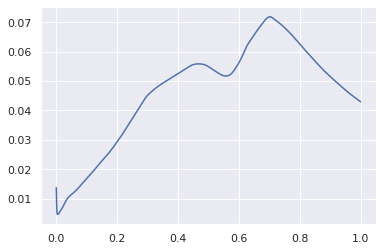

In [264]:
plt.plot(nosymp_other_x, nosymp_other_y)
plt.show()

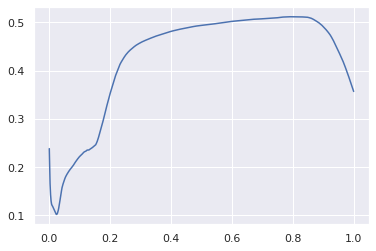

In [265]:
plt.plot(nosymp_abroad_x, nosymp_abroad_y)
plt.show()

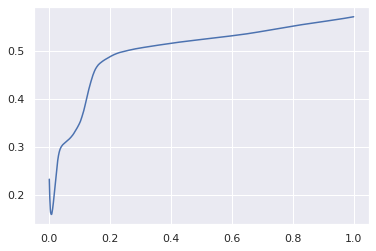

In [266]:
plt.plot(nosymp_contact_x, nosymp_contact_y)
plt.show()

In [408]:
model.eval()

pred = []
positive_res_data = []
negative_res_data = []
for test_data in tqdm(test_dataloader):
        
    test_inputs, test_labels = test_data
    print(test_inputs)
#     break
    test_inputs = torch.unsqueeze(test_inputs, 1)
    test_outputs = model(torch.Tensor(test_inputs).to(device))
    test_outputs = torch.sigmoid(test_outputs)
    if test_outputs[0][0].item() > 0.5:
        pred.append([1])
        positive_res_data.append(test_inputs.numpy().tolist())
    else:
        pred.append([0])
        negative_res_data.append(test_inputs.numpy().tolist())
    break

  0%|          | 0/1069182 [00:00<?, ?it/s]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3348, 0.3333,
         0.0000]])


In [178]:
import pickle 

with open("./base_pred.pkl", "wb") as fp:
    pickle.dump(pred, fp)
    
with open("./base_positive_res_data.pkl", "wb") as fp:
    pickle.dump(positive_res_data, fp)
    
with open("./base_negative_res_data.pkl", "wb") as fp:
    pickle.dump(negative_res_data, fp)

In [179]:
import pickle

In [183]:
pred = []
positive_res_data = []
negative_res_data = []

with open("./base_pred.pkl", "rb") as fp:
    pred = pickle.load(fp)
    
with open("./base_positive_res_data.pkl", "rb") as fp:
    positive_res_data = pickle.load(fp)
    
with open("./base_negative_res_data.pkl", "rb") as fp:
    negative_res_data = pickle.load(fp)

In [ ]:
# def display_performance(pred, valid_gt):
#     pred = np.array(pred)

#     print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
#     print('precision %.4f' % (precision_score(pred, valid_gt)))
#     print('recall %.4f' % (recall_score(pred, valid_gt)))
#     print('f1-score %.4f' % (f1_score(pred, valid_gt)))
#     print(confusion_matrix(pred, valid_gt))
#     fper, tper, thresholds = roc_curve(pred, valid_gt)
#     print(tper)
#     print(fper)
#     print(thresholds)
#     print(roc_auc_score(valid_gt, pred))
#     optimal_idx = np.argmax(tper - fper)
#     optimal_threshold = thresholds[optimal_idx]
#     print("Threshold value is:", optimal_threshold)
#     # plot_roc_curve(fpr, tpr)
#     plot_roc_curve(fper, tper)

### 8-feature - epoch 1
- accuracy 0.8779
- precision 0.2652
- recall 0.4887
- f1-score 0.3438

### 8-feature - epoch 10
- accuracy 0.1348
- precision 0.9928
- recall 0.1217
- f1-score 0.2169

### 9-feature(isolated_today_contact_with_confirmed or new_contact_with_confirmed)
- accuracy 0.8793
- precision 0.0000
- 모두 음성으로 판단하는 대참사

### 9-feature(isolated_today_contact_with_confirmed or new_contact_with_confirmed) - epoch 5
- accuracy 0.8699
- precision 0.5792
- recall 0.4685
- f1-score 0.5180

### 9-feature(contact) - epoch 20
- accuracy 0.8702
- precision 0.2208
- recall 0.4144
- f1-score 0.2881

### 9-feature(positive ratio) - epoch 20
- accuracy 0.7904
- precision 0.5766
- recall 0.3010
- f1-score 0.3956

### 10-feature( 'positive_ratio', 'contact') - epoch 20
- accuracy 0.8713
- precision 0.5797
- recall 0.4671
- f1-score 0.5174

### 12-feature('contact', 'positive_ratio', 'weekday_ratio', 'confirmed_ratio') - epoch 20
- accuracy 0.8698
- precision 0.5809
- recall 0.4650
- f1-score 0.5166


accuracy 0.8793
precision 0.1684
recall 0.4877
f1-score 0.2503
[[740307  85788]
 [ 18244  17368]]

In [177]:
# 'cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'confirmed_ratio', 'weekday_ratio', 'corona_result'

In [ ]:
df_pos = pd.DataFrame(np.array(positive_res_data).reshape(-1, 8), columns=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication'])
df_neg = pd.DataFrame(np.array(negative_res_data).reshape(-1, 8), columns=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication'])

In [ ]:
print(f"양성 갯수: {df_pos.shape[0]}, 음성 갯수: {df_neg.shape[0]}, 양성 / 음성 비율: {round(df_pos.shape[0] / df_neg.shape[0] * 100, 2)}%")

In [ ]:
df_pos_symptom_cnt = [0] * 6
df_neg_symptom_cnt = [0] * 6
pos_symptom_confusion_matrix = np.zeros((2,2,2,2,2), dtype=int)
neg_symptom_confusion_matrix = np.zeros((2,2,2,2,2), dtype=int)

for idx, row in tqdm(df_pos.iterrows()):
    symptoms = row[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']].astype(int).tolist()
    pos_symptom_confusion_matrix[symptoms[0], symptoms[1], symptoms[2], symptoms[3], symptoms[4]] += 1
    cnt_idx = int(sum(symptoms))
    df_pos_symptom_cnt[cnt_idx] += 1
    
for idx, row in tqdm(df_neg.iterrows()):
    #     if idx == df_pos.shape[0]: break
    symptoms = row[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']].astype(int).tolist()
    neg_symptom_confusion_matrix[symptoms[0], symptoms[1], symptoms[2], symptoms[3], symptoms[4]] += 1
    cnt_idx = int(sum(symptoms))
    df_neg_symptom_cnt[cnt_idx] += 1

In [ ]:
df_pos.shape[0], df_neg.shape[0]

In [ ]:
def positive_percent_of_ormore_number(number):
    neg_ormore_num = sum(df_neg_symptom_cnt[number:])
    pos_ormore_num = sum(df_pos_symptom_cnt[number:])
    total = neg_ormore_num + pos_ormore_num
    if total == 0: 'lower the number'
    return round((pos_ormore_num / total) * 100, 2)

In [ ]:
print(f"음성 예측 데이터 [0개, 1개, 2개, 3개, 4개, 5개] : {df_neg_symptom_cnt[:6]}")
print(f"양성 예측 데이터 [0개, 1개, 2개, 3개, 4개, 5개] : {df_pos_symptom_cnt[:6]}\n")

for number in range(6):
    print(f"{number}개 이상] {positive_percent_of_ormore_number(number)}% 양성")
    print(f"증상 {number}개] 음성/양성% : {round(df_neg_symptom_cnt[number] / df_pos_symptom_cnt[number]*100, 2)}%\n")

In [ ]:
pos_symptom_confusion_matrix

In [ ]:
def confusion_matrix_display(confusion_matrix):
    for i in range(32):
        idx = bin(i).replace("0b", "0" * (7-len(bin(i))))
        cnt = 0
        if idx[0] == '1': 
            print('[ cough',end = ' ')
            cnt += 1
        if idx[1] == '1': 
            print('fever',end = ' ')
            cnt += 1
        if idx[2] == '1': 
            print('sore_throat',end = ' ')
            cnt += 1
        if idx[3] == '1': 
            print('shortness_of_breath',end = ' ')
            cnt += 1
        if idx[4] == '1': 
            print('head_ache',end = ' ')
            cnt += 1
        print(f'{cnt}개 증상 ]')
            
        print(confusion_matrix[int(idx[0]),int(idx[1]),int(idx[2]),int(idx[3]),int(idx[4])])

In [ ]:
confusion_matrix_display(neg_symptom_confusion_matrix)

In [ ]:
confusion_matrix_display(pos_symptom_confusion_matrix)

In [ ]:
pred = np.array(pred)

print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
print('precision %.4f' % (precision_score(pred, valid_gt)))
print('recall %.4f' % (recall_score(pred, valid_gt)))
print('f1-score %.4f' % (f1_score(pred, valid_gt)))
print(confusion_matrix(pred, valid_gt))

In [ ]:
pred
# pred_chk

### random forest result
- accuracy 0.9257
- precision 0.2314
- recall 0.5553
- f1-score 0.3267
- [[791936  52206]
- [ 12591  15720]]

### 1-layer sigmoid epoch3 result
- accuracy 0.9222
- precision 0.1958
- recall 0.5013
- f1-score 0.2816
- [[791299  54627]
- [ 13228  13299]]

### compare with logistic regression
- accuracy 0.9224
- precision 0.1953
- recall 0.5049
- f1-score 0.2816
- [[791517  54661]
- [ 13010  13265]]

### 2-layer epoch3 result
- 8-4-1(sig-sig)
- accuracy 0.9248
- precision 0.2626
- recall 0.5342
- f1-score 0.3521
- [[788976  50090]
-  [ 15551  17836]]

### 2-layer epoch3 result
- 8-4-1(relu-sig)
- accuracy 0.9256 
- precision 0.1999
- recall 0.5635
- f1-score 0.2951
- [[794008  54349]
- [ 10519  13577]]

### 2-layer epoch3 result
- 8-20-1(relu-sig)
- accuracy 0.9255
- precision 0.2392
- recall 0.5498
- f1-score 0.3333
- [[791226  51680]
-  [ 13301  16246]]

### 2-layer epcoh3 result 
- 8-400-1(relu-sig)
- accuracy 0.9256
- precision 0.2904
- recall 0.5415
- f1-score 0.3781
- [[787821  48197]
- [ 16706  19729]]

### 3-layer epoch3 result
- 8-4-2-1 (relu-relu-sigmoid) (sigmoid-sigmoid-sigmoid 동일한 결과)
- accuracy 0.9221
- precision 0.0000
- recall 0.0000
- f1-score 0.0000
- [[804527  67926]
-  [     0      0]]
- 확인 결과 모든 출력을 음성으로 출력함(1-layer가 오히려 낫네?)

## 시간 순서대로 train, valid, test 나눔

### Logistic Regression
- accuracy 0.8782
- precision 0.2240
- recall 0.4901
- f1-score 0.3075
- [[742649  81690]
  [ 24533  23581]]
  
### Random Forest
- accuracy 0.8761
- precision 0.4298
- recall 0.4848
- f1-score 0.4556
- [[719101  60026]
- [ 48081  45245]]

### Decision Tree
- accuracy 0.8761
- precision 0.4299
- recall 0.4848
- f1-score 0.4557
- [[719094  60017]
- [ 48088  45254]]

### Gradient Boosting 
- accuracy 0.8789
- precision 0.3059
- recall 0.4973
- f1-score 0.3788
- [[734633  73070]
- [ 32549  32201]]

### 3-layer NN 
- epochs = 10, batch_size = 128
- 8-1200-1
- accuracy 0.8699
- precision 0.5794
- recall 0.4683
- f1-score 0.5180
- [[697921  44274]
- [ 69261  60997]]

In [3]:
test_json = {
  "baby_id": "11111",
  "user_id": "11113",
  "timestamp": "",
  "input_data": {
    "COVID_SELF_CHECK": {
      "3": "5",
      "4": [
        "104",
        "107",
        "102"
      ]
    },
    "BASIC_INFO_01": {
      "3": "5",
      "4": [
        "104",
        "107",
        "102"
      ]
    },
    "UNDERLYING_DISEASE_QNA_01": {
      "3": "5",
      "4": [
        "104",
        "107",
        "102"
      ]
    },
    "UNDERLYING_DISEASE_QNA_02": {
      "3": "5",
      "4": [
        "104",
        "107",
        "102"
      ]
    },
    "BASIC_INFO_02": {
      "3": "5",
      "4": [
        "104",
        "107",
        "102"
      ]
    }
  }
}

In [4]:
import numpy as np

def json_to_np(json):
    baby_id = json['baby_id']
    user_id = json['user_id']
    return np.array([baby_id, user_id])

In [6]:
json_to_np(test_json)

array(['11111', '11113'], dtype='<U5')

In [ ]:
def input_data_to_np(input_data):

In [16]:
input_data = {
    "COVID_SELF_CHECK": {
      "3": "5",
      "4": [
        "104",
        "107",
        "102"
      ]
    },
    "BASIC_INFO_01": {
      "3": "5",
      "4": [
        "104",
        "107",
        "102"
      ]
    },
    "UNDERLYING_DISEASE_QNA_01": {
      "3": "5",
      "4": [
        "104",
        "107",
        "102"
      ]
    },
    "UNDERLYING_DISEASE_QNA_02": {
      "3": "5",
      "4": [
        "104",
        "107",
        "102"
      ]
    },
    "BASIC_INFO_02": {
      "3": "5",
      "4": [
        "104",
        "107",
        "102"
      ]
    }
}   

In [17]:
input_data

{'COVID_SELF_CHECK': {'3': '5', '4': ['104', '107', '102']},
 'BASIC_INFO_01': {'3': '5', '4': ['104', '107', '102']},
 'UNDERLYING_DISEASE_QNA_01': {'3': '5', '4': ['104', '107', '102']},
 'UNDERLYING_DISEASE_QNA_02': {'3': '5', '4': ['104', '107', '102']},
 'BASIC_INFO_02': {'3': '5', '4': ['104', '107', '102']}}

In [18]:
input_data.values()

dict_values([{'3': '5', '4': ['104', '107', '102']}, {'3': '5', '4': ['104', '107', '102']}, {'3': '5', '4': ['104', '107', '102']}, {'3': '5', '4': ['104', '107', '102']}, {'3': '5', '4': ['104', '107', '102']}])